![ML Logo](https://raw.githubusercontent.com/chicochica10/utad-spark-ml/master/images/utad-spark-ml.1x_Banner_300.png)
# **Lab de predicción de tasas de clics**
#### Este lab cubre los pasos para crear un pipeline de predición de tasas de clics. Trabajarás con el dataset de [Criteo Labs](http://labs.criteo.com/) que se usó en la  [competición Kaggle](https://www.kaggle.com/c/criteo-display-ad-challenge).
#### ** Este lab cubre: **
+  ####*Parte 1:* Caracterización categórica de datos utilizando one-hot-encoding (OHE)
+  ####*Parte 2:* Construcción del diccionario OHE
+  ####*Part 3:* Parseo de datos CTR y generación de características OHE
 + #### *Visualización 1:* Frecuencia de características 
+  ####*Parte 4:* predicción CTR y evaluación logloss
 + #### *Visualización 2:* curva ROC
 
#### como referencia tienes los métodods de spark más relevantes en [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) y los métodos de NumPy en [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

### **Parte 1: Caracterización categórica de datos utilizando one-hot-encoding (OHE)**

#### ** (1a) One-hot-encoding **
#### vamos a desarrollar código para convertir características categóricas a numéricas, trabajaremos con un dataset de ejemplo no etiquetado con 3 data points que representan a un animal. La primera característica indica el tipo del animal (bear, cat, mouse), la segunda característica indica el color (black, tabby) y la tercera (opcional) describe lo que el animal come (mouse, salmon).

#### En el esquema OHE queremos representar cada tupla de `(featureID, category)` via su  propia representacion binaria. Podemos hacer esto en Python creando un diccionario que mapee cada tupla a un entero distinto donde cada entero corresponda a una característica binaria. para empezar se introducen manualmente la entradas en el diccionario OHE asociado al dataset de ejemplo mapeando las tuplas a enterors consecutivos empezando desde cero y ordenando las tuplas primero por featureID y después por categoria.

#### Después en el lab usaremos los diccionarios OHE para transformar data points en una lista más compacta de características que se pueden utilizar en algoritmos de machine learning.

In [1]:
# Datos para la entrada manual OHE
# Nota: el primer data point no incluye ningún valor para la tercera característica opcional
sampleOne = [(0, 'mouse'), (1, 'black')]
sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]
sampleDataRDD = sc.parallelize([sampleOne, sampleTwo, sampleThree])

In [2]:
#TODO: Reemplaza <RELLENA> con el código apropiado
sampleOHEDictManual = {}
sampleOHEDictManual[(0,'bear')] = 0
sampleOHEDictManual[(0,'cat')] = 1
sampleOHEDictManual[(0,'mouse')] = 2
sampleOHEDictManual[(1,'black')] = 3
sampleOHEDictManual[(1,'tabby')] = 4
sampleOHEDictManual[(2,'mouse')] = 5
sampleOHEDictManual[(2,'salmon')] = 6

In [3]:
# TEST One-hot-encoding (1a)
from test_helper import Test

Test.assertEqualsHashed(sampleOHEDictManual[(0,'bear')],
                        'b6589fc6ab0dc82cf12099d1c2d40ab994e8410c',
                        "valor incorrecto para sampleOHEDictManual[(0,'bear')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'cat')],
                        '356a192b7913b04c54574d18c28d46e6395428ab',
                        "valor incorrecto para sampleOHEDictManual[(0,'cat')]")
Test.assertEqualsHashed(sampleOHEDictManual[(0,'mouse')],
                        'da4b9237bacccdf19c0760cab7aec4a8359010b0',
                        "valor incorrecto para sampleOHEDictManual[(0,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'black')],
                        '77de68daecd823babbb58edb1c8e14d7106e83bb',
                        "valor incorrecto para sampleOHEDictManual[(1,'black')]")
Test.assertEqualsHashed(sampleOHEDictManual[(1,'tabby')],
                        '1b6453892473a467d07372d45eb05abc2031647a',
                        "valor incorrecto para sampleOHEDictManual[(1,'tabby')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'mouse')],
                        'ac3478d69a3c81fa62e60f5c3696165a4e5e6ac4',
                        "valor incorrecto para sampleOHEDictManual[(2,'mouse')]")
Test.assertEqualsHashed(sampleOHEDictManual[(2,'salmon')],
                        'c1dfd96eea8cc2b62785275bca38ac261256e278',
                        "valor incorrecto para sampleOHEDictManual[(2,'salmon')]")
Test.assertEquals(len(sampleOHEDictManual.keys()), 7,
                  'numero de claves incorrecto sampleOHEDictManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (1b) Vectores Sparse **
#### Los data points se pueden representar con un pequeño número de características OHE no-cero relativas al número total de características que hay en el dataset. Aprovechando esta escasez y  usando represetación de vectores sparse en los datos OHE podemos reducir los costes de almacenamiento y computacionales. Abajo hay unos pocos ejemplos de vectores representados como arrays densos de numpy. Utiliza   [SparseVector](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.SparseVector) para representarlos de forma sparse y verifica que tanto las representaciones dense como sparse devuelven los mismos resultados cuando se calcula el [dot products](http://en.wikipedia.org/wiki/Dot_product) (más adelante utilizaremos Mlib para entrenar clasificadores vía el descenso del gradiente y MLib necesitará estos vectores computar el dot product entre SparseVector y vectores densos de parámetros).

#### Utiliza  `SparseVector(size, *args)`  para crear un nuevo vector sparse donde el tamaño es la longitud del vector y los argumentos puedan ser un diccionario , una lista de  pares (index, value) o dos arrays separados de índices y valores ordenados por índices. Necesitarás crear una representación de un vector sparse por cada vector dendos `aDense` y `bDense`.

In [4]:
import numpy as np
from pyspark.mllib.linalg import SparseVector

In [5]:
#TODO: Reemplaza <RELLENA> con el código apropiado
aDense = np.array([0., 3., 0., 4.])
aSparse = SparseVector (4, [(1,3.),(3,4.)])

bDense = np.array([0., 0., 0., 1.])
bSparse = SparseVector (4,[(3,1.)])

w = np.array([0.4, 3.1, -1.4, -.5])
print aDense.dot(w)
print aSparse.dot(w)
print bDense.dot(w)
print bSparse.dot(w)

7.3
7.3
-0.5
-0.5


In [6]:
# TEST Sparse Vectors (1b)
Test.assertTrue(isinstance(aSparse, SparseVector), 'aSparse tiene que ser una instancia de SparseVector')
Test.assertTrue(isinstance(bSparse, SparseVector), 'aSparse tiene que ser una instancia de SparseVector')
Test.assertTrue(aDense.dot(w) == aSparse.dot(w),
                'dot product de aDense y w debería ser igual al dot product de aSparse y w')
Test.assertTrue(bDense.dot(w) == bSparse.dot(w),
                'dot product de bDense y w debería ser igual al dot product de bSparse y w')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1c) características OHE  como vectores sparse **
#### Ahora veamos como se pueden representar las características OHE para los puntos en nuestro dataset de ejemplo.  Usando el mapeo definido por el diccionario de OHE de la parte (1a), define manualmente las característica de OHE para los tres data points de ejemplo usando el formato SparseVector. Cualquier característica que ocurra en un punto debería tener el valor 1.0. Por ejemplo, el  `DenseVector` para un punto con características 2 y 4 debería de ser  `[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]`.

In [7]:
# características de ejemplo
# sampleOne = [(0, 'mouse'), (1, 'black')]
# sampleTwo = [(0, 'cat'), (1, 'tabby'), (2, 'mouse')]
# sampleThree =  [(0, 'bear'), (1, 'black'), (2, 'salmon')]

In [8]:
# TODO: Replace <FILL IN> with appropriate code
sampleOneOHEFeatManual = SparseVector (len(sampleOHEDictManual),[(sampleOHEDictManual[(0,'mouse')],1), 
                                          (sampleOHEDictManual[(1,'black')],1)])
sampleTwoOHEFeatManual = SparseVector (len(sampleOHEDictManual),[(sampleOHEDictManual[(0,'cat')],1),
                                          (sampleOHEDictManual[(1,'tabby')],1),
                                          (sampleOHEDictManual[(2,'mouse')],1)])
sampleThreeOHEFeatManual = SparseVector (len (sampleOHEDictManual),[(sampleOHEDictManual[(0,'bear')],1),
                                            (sampleOHEDictManual[(1,'black')],1),
                                            (sampleOHEDictManual[(2,'salmon')],1)])


In [9]:
# TEST de características OHE como vectores sparse (1c)
Test.assertTrue(isinstance(sampleOneOHEFeatManual, SparseVector),
                'sampleOneOHEFeatManual debe ser SparseVector')
Test.assertTrue(isinstance(sampleTwoOHEFeatManual, SparseVector),
                'sampleTwoOHEFeatManual debe ser SparseVector')
Test.assertTrue(isinstance(sampleThreeOHEFeatManual, SparseVector),
                'sampleThreeOHEFeatManual debe ser SparseVector')
Test.assertEqualsHashed(sampleOneOHEFeatManual,
                        'ecc00223d141b7bd0913d52377cee2cf5783abd6',
                        'valor incorrecto para sampleOneOHEFeatManual')
Test.assertEqualsHashed(sampleTwoOHEFeatManual,
                        '26b023f4109e3b8ab32241938e2e9b9e9d62720a',
                        'valor incorrecto para sampleTwoOHEFeatManual')
Test.assertEqualsHashed(sampleThreeOHEFeatManual,
                        'c04134fd603ae115395b29dcabe9d0c66fbdc8a7',
                        'valor incorrecto para sampleThreeOHEFeatManual')

1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### **(1d) Definir una función OHE **
#### A continuación usaremos el diccionario de la parte (1a) para generar programáticamente las características OHE de los datos categóricos originales. Primero escribiremos una función llamada  `oneHotEncoding` que cree un vector de características OHe en el formato  `SparseVector`. Después utilizaremos esta función para crear las características OHE para primer datapoint de ejemplo y verificaremos que el resultado es igual que el de la parte (1c).

In [10]:
# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        You should ensure that the indices used to create a SparseVector are sorted.
    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    lista =[]
    """[(OHEDict[(0,'mouse')],1.0), (OHEDict[(1,'black')],1.0)]
    """
    for i in rawFeats:
        lista.append ((OHEDict [i], 1.0))
    return SparseVector (numOHEFeats,lista)

# Calculate the number of features in sampleOHEDictManual
numSampleOHEFeats = len (sampleOHEDictManual)

# Run oneHotEnoding on sampleOne
sampleOneOHEFeat = oneHotEncoding (sampleOne, sampleOHEDictManual, numSampleOHEFeats)

print sampleOneOHEFeat


(7,[2,3],[1.0,1.0])


In [11]:
# TEST Define an OHE Function (1d)
Test.assertTrue(sampleOneOHEFeat == sampleOneOHEFeatManual,
                'sampleOneOHEFeat deberia ser igual sampleOneOHEFeatManual')
Test.assertEquals(sampleOneOHEFeat, SparseVector(7, [2,3], [1.0,1.0]),
                  'valor incorrecto para sampleOneOHEFeat')
Test.assertEquals(oneHotEncoding([(1, 'black'), (0, 'mouse')], sampleOHEDictManual,
                                 numSampleOHEFeats), SparseVector(7, [2,3], [1.0,1.0]),
                  'definicion incorrecta para oneHotEncoding')

1 test passed.
1 test passed.
1 test passed.


#### **(1e) aplicar OHE al dataset **
#### Finalmente utilizar la función de la parte (1d) para crear características OHE  para 3 datapoints del dataset de ejemplo.

In [13]:
#TODO: Reemplaza <RELLENA> con el código apropiado
sampleOHEData = sampleDataRDD.map (lambda sample: oneHotEncoding (sample, sampleOHEDictManual, numSampleOHEFeats))
print sampleOHEData.collect()

[SparseVector(7, {2: 1.0, 3: 1.0}), SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}), SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0})]


In [14]:
# TEST aplicar OHE  a un dataset (1e)
sampleOHEDataValues = sampleOHEData.collect()
Test.assertTrue(len(sampleOHEDataValues) == 3, 'sampleOHEData deberia tener 3 elemenos')
Test.assertEquals(sampleOHEDataValues[0], SparseVector(7, {2: 1.0, 3: 1.0}),
                  'OHE incorrecto para el primer ejemplo')
Test.assertEquals(sampleOHEDataValues[1], SparseVector(7, {1: 1.0, 4: 1.0, 5: 1.0}),
                  'OHE incorrecto para el segundo ejemplo')
Test.assertEquals(sampleOHEDataValues[2], SparseVector(7, {0: 1.0, 3: 1.0, 6: 1.0}),
                  'OHE incorrecto para el tercer ejemplo')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


### ** Parte 2: Construcción del diccionario OHE **

#### **(2a)  RDD de pares `(featureID, category)` **
#### Para empezar crea un RDD de tuplas distintas `(featureID, category)`. En nuestro dataset de ejemplo los 7 items en RDD resultante son `(0, 'bear')`, `(0, 'cat')`, `(0, 'mouse')`, `(1, 'black')`, `(1, 'tabby')`, `(2, 'mouse')`, `(2, 'salmon')`.  `'black'` aparece dos veces en el dataset pero solamente uno de los items contribuye al RDD: `(1, 'black')`, mientras `'mouse'` aparece dos veces y contribuye a dos items: `(0, 'mouse')` and `(2, 'mouse')`.  Usa [flatMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.flatMap) y [distinct](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.distinct).

In [15]:
#TODO: Reemplaza <RELLENA> con el código apropiado
sampleDistinctFeats = (sampleDataRDD.flatMap (lambda list: list)).distinct()


In [16]:
# TEST pares de RDD de (featureID, category) (2a)
Test.assertEquals(sorted(sampleDistinctFeats.collect()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'valor incorrecto para sampleDistinctFeats')

1 test passed.


#### ** (2b) Diccionario OHE Dictionary para distintas características  **
#### A continuación, crea un `RDD` de tuplas clave-valor donde cada  tupla `(featureID, category)` en `sampleDistinctFeats` es una clave y los valores son entereos distintos desde 0 a (número de claves -1). Convierte este  `RDD` en un diccionario que pueda ser usado en la acción  `collectAsMap`. Nota que no hay un único mapeo de claves a valores todo lo que se requieres es que cada `(featureID, category)` clave se mapee a un entero único entre 0 y el número de claves. En este ejercicio, cualquier mapeo válido es aceptable. Utiliza [zipWithIndex](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.zipWithIndex) seguido de  [collectAsMap](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.collectAsMap).
#### En nuestro dataset de ejemplo una lista de tuplas clave-valor válida es: `[((0, 'bear'), 0), ((2, 'salmon'), 1), ((1, 'tabby'), 2), ((2, 'mouse'), 3), ((0, 'mouse'), 4), ((0, 'cat'), 5), ((1, 'black'), 6)]`. El diccionario definido en la parte (1a) muestra otro mapeo válido entre claves y enteros.

In [17]:
#TODO: Reemplaza <RELLENA> con el código apropiado
sampleOHEDict = (sampleDistinctFeats.zipWithIndex().collectAsMap())
print sampleOHEDict

{(2, 'mouse'): 0, (0, 'cat'): 1, (0, 'bear'): 2, (2, 'salmon'): 3, (1, 'tabby'): 4, (1, 'black'): 5, (0, 'mouse'): 6}


In [18]:
# TEST Diccionario OHE para distintas características (2b)
Test.assertEquals(sorted(sampleOHEDict.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDict has unexpected keys')
Test.assertEquals(sorted(sampleOHEDict.values()), range(7), 'sampleOHEDict tiene valores no esperados')

1 test passed.
1 test passed.


#### **(2c) Creación automática de un diccionario OHE **
#### Usa el código de las partes (2a) y (2b) para escribir una función que tome un dataset de entrada y como salida un diccionario OHE. Usa esta función para acrear un diccionario OHE con el dataset de ejemplo y verifica que es igual que el diccionario de la parte (2b).

In [19]:
# TODO: Replace <FILL IN> with appropriate code
def createOneHotDict(inputData):
    """Creates a one-hot-encoder dictionary based on the input data.
    Args:
        inputData (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.
    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    
    return inputData.flatMap (lambda list: list).distinct().zipWithIndex().collectAsMap()

sampleOHEDictAuto = createOneHotDict (sampleDataRDD)
print sampleOHEDictAuto


{(2, 'mouse'): 0, (0, 'cat'): 1, (0, 'bear'): 2, (2, 'salmon'): 3, (1, 'tabby'): 4, (1, 'black'): 5, (0, 'mouse'): 6}


In [20]:
# TEST Creación automática de un diccionario OHE (2c)
Test.assertEquals(sorted(sampleOHEDictAuto.keys()),
                  [(0, 'bear'), (0, 'cat'), (0, 'mouse'), (1, 'black'),
                   (1, 'tabby'), (2, 'mouse'), (2, 'salmon')],
                  'sampleOHEDictAuto has unexpected keys')
Test.assertEquals(sorted(sampleOHEDictAuto.values()), range(7),
                  'sampleOHEDictAuto has unexpected values')

1 test passed.
1 test passed.


### **Parte 3: Parseo de datos CTR y generación de características OHE**

#### **(3a) Carga y split de datos **
#### Ahora estamos listo para trabajar con datos CTR reales y nuestra primera tarea será dividirlos en sets de training, validación y test usando[randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) con los pesos y semillas especificados para crear RDDs que almacenen cada uno de estos dataset y entonces hacer [cache](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.cache) en cada uno de los RDDs ya que se van a acceder multiples veces.

In [27]:
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('utad-spark-ml', 'cad.txt')
fileName = os.path.join(baseDir, inputPath)

if os.path.isfile(fileName):
    rawData = (sc
               .textFile(fileName, 2)
               .map(lambda x: x.replace('\t', ',')))
    print rawData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [28]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights,seed)
# Cache the data
rawTrainData.cache()
rawValidationData.cache()
rawTestData.cache()

nTrain = rawTrainData.count()
nVal = rawValidationData.count()
nTest = rawTestData.count()

print nTrain, nVal, nTest, nTrain + nVal + nTest
print rawData.take(1)

1596 210 193 1999
[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


In [29]:
# TEST Loading and splitting the data (3a)
Test.assertTrue(all([rawTrainData.is_cached, rawValidationData.is_cached, rawTestData.is_cached]),
                'debes cachear los datos')
Test.assertEquals(nTrain, 1596, 'valor incorrecto para nTrain')
Test.assertEquals(nVal, 210, 'valor incorrecto para nVal')
Test.assertEquals(nTest, 193, 'valor incorrecto para nTest')

1 test passed.
1 test passed.
1 test passed.
1 test passed.


#### ** (3b) Extraer características **
#### parsearemos el dataset en bruto de training para crear un RDD que sirva para crear un directorio OHE. Nota que el comando `take()` en la parte (3a) que es un data point es un string que contiene varios campos separados por un delimitador. De momento vamos a ignorar el primer campo (que es una etiqueta 0-1) y parsear el resto de los campos. Completa la función `parsePoint`.

In [30]:
def parsePoint(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.
    Note:
        featureIDs should start at 0 and increase to the number of features - 1.
    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
    Returns:
        list: A list of (featureID, value) tuples.
    """
    lista =[]
         
    labelFeatures = point.split (",")
    features = labelFeatures[1:]
    i = 0
    for feature in features:
        lista.append ((i,feature))
        i = i + 1
    return lista

#point = "0,1,2,3,4"
#print (parsePoint (point))

parsedTrainFeat = rawTrainData.map(parsePoint)

numCategories = (parsedTrainFeat
                 .flatMap(lambda x: x)
                 .distinct()
                 .map(lambda x: (x[0], 1))
                 .reduceByKey(lambda x, y: x + y)
                 .sortByKey()
                 .collect())

#print numCategories
print numCategories[2][1]


135


In [32]:
# TEST Extraer características (3b)
Test.assertEquals(numCategories[2][1], 135, 'implementación incorrecta de parsePoint')
Test.assertEquals(numCategories[32][1], 4, 'implementación incorrecta de parsePoint')

1 test passed.
1 test passed.


#### **(3c) crear un diccionario OHE para el dataset **
#### parsePoint devuelve un data point como una lista de tuplas `(featureID, category)`  que tienen el mismo formato que el dataset estudiado en las partes 1 y 2. Crea un diccionario OHE que use la función implementada en la parte (2c). Asumimos por simplicidad que todas las características en el dataset son categóricas.

In [33]:
#TODO: Reemplaza <RELLENA> con el código apropiado
ctrOHEDict = createOneHotDict (parsedTrainFeat)
numCtrOHEFeats = len(ctrOHEDict.keys())
print numCtrOHEFeats
print ctrOHEDict[(0, '')]

13752
4038


In [34]:
# TEST crear un diccionario OHE para el dataset (3c)
Test.assertEquals(numCtrOHEFeats, 13752, 'numero incorrecto de características en ctrOHEDict')
Test.assertTrue((0, '') in ctrOHEDict, 'características incorrectas en ctrOHEDict')

1 test passed.
1 test passed.


#### ** (3d) Aplicar OHE al dataset **
#### Usemos ahora el diccionario OHE empezando con los datos en bruto del training creando un RDD de objetos [LabeledPoint](http://spark.apache.org/docs/1.3.1/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) que usen las características OHE. Para hacer esto completa la implementación de la función `parseOHEPoint` . Sugerencia: `parseOHEPoint` es una extensión de la función `parsePoint`  de la parte (3b) y usa la función `oneHotEncoding` de la parte (1d).

In [35]:
from pyspark.mllib.regression import LabeledPoint

In [36]:
#TODO: Reemplaza <RELLENA> con el código apropiado
def parseOHEPoint(point, OHEDict, numOHEFeats):
    """Obtain the label and feature vector for this raw observation.
    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.
    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The number of unique features in the training dataset.
    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    
    
    labelFeatures = point.split (",")
    label = labelFeatures[0]
    return LabeledPoint (label,oneHotEncoding(parsePoint(point), OHEDict, numOHEFeats))

OHETrainData = rawTrainData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHETrainData.cache()
print OHETrainData.take(1)

# Check that oneHotEncoding function was used in parseOHEPoint
backupOneHot = oneHotEncoding
oneHotEncoding = None
withOneHot = False
try: parseOHEPoint(rawTrainData.take(1)[0], ctrOHEDict, numCtrOHEFeats)
except TypeError: withOneHot = True
oneHotEncoding = backupOneHot


[LabeledPoint(0.0, (13752,[173,681,1152,1927,1939,2170,2521,2684,2757,3316,3450,3761,4212,4510,4557,4843,4920,5144,5175,5586,6011,6527,6683,7291,7293,7480,7605,7790,8994,10449,11421,11763,11973,12045,12261,12469,12527,12742,13274],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [38]:
# TEST Aplicar OHE al dataset (3d)
numNZ = sum(parsedTrainFeat.map(lambda x: len(x)).take(5))
numNZAlt = sum(OHETrainData.map(lambda lp: len(lp.features.indices)).take(5))
Test.assertEquals(numNZ, numNZAlt, 'implementación incorrecta en parseOHEPoint')
Test.assertTrue(withOneHot, 'oneHotEncoding no presente en parseOHEPoint')

1 test passed.
1 test passed.


#### *Visualización 1: Frecuencia de características **
#### visualizaremos ahora el número de veces que aparecen las características OHE en el dataset de training. Primero se calculará el numero que aparece cada característica, después el 'bucket' de características para esas cuentas. los 'buckets' tienen un tamaño de potencia de 2 de modo que el primer 'bucket' se corresponde con características que aparecen exactamente 1 vez ( $ \scriptsize 2^0 $ ), el segundo con características que aparecen dos veces ( $ \scriptsize 2^1 $ ) el tercero con características que aparecen entre 3 y 4 ( $ \scriptsize 2^2 $ ) veces, el quinto de 5 a 8  ( $ \scriptsize 2^3 $ ) etc.. el gráfico muestra el logaritmo de los límites de los 'buckets' vs el logaritmo del número de características que tienen el contador que cae dentro de los 'buckets'

In [39]:
def bucketFeatByCount(featCount):
    """Bucket the counts by powers of two."""
    for i in range(11):
        size = 2 ** i
        if featCount <= size:
            return size
    return -1

featCounts = (OHETrainData
              .flatMap(lambda lp: lp.features.indices)
              .map(lambda x: (x, 1))
              .reduceByKey(lambda x, y: x + y))
featCountsBuckets = (featCounts
                     .map(lambda x: (bucketFeatByCount(x[1]), 1))
                     .filter(lambda (k, v): k != -1)
                     .reduceByKey(lambda x, y: x + y)
                     .collect())
print featCountsBuckets

[(32, 152), (1024, 14), (2, 1607), (4, 921), (8, 445), (64, 76), (128, 60), (256, 27), (16, 309), (512, 22), (1, 10115)]


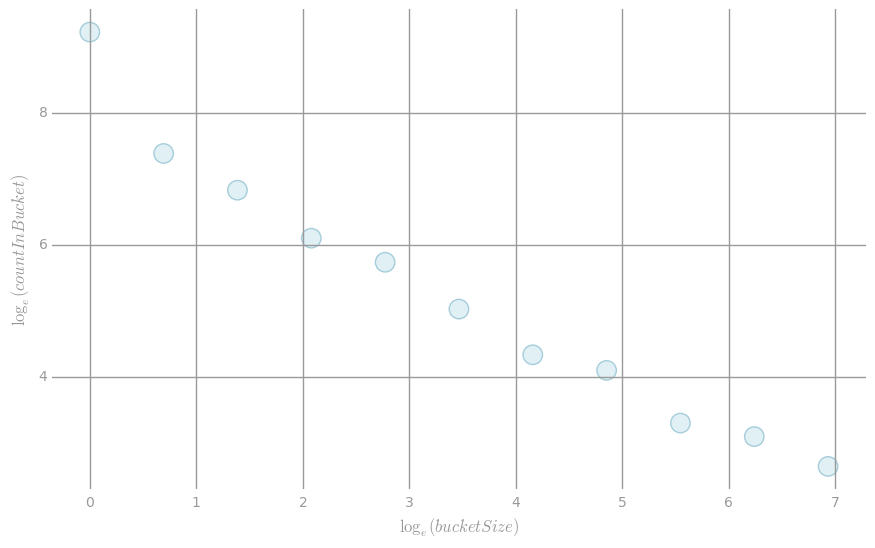

In [40]:
import matplotlib.pyplot as plt

x, y = zip(*featCountsBuckets)
x, y = np.log(x), np.log(y)

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 10, 1), np.arange(4, 14, 2))
ax.set_xlabel(r'$\log_e(bucketSize)$'), ax.set_ylabel(r'$\log_e(countInBucket)$')
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
pass

#### **(3e) características no vistas **
#### Naturalmente queremos repetir el proceso de la parte (3d) para computar características OHE para los dataset de validación y de test. Sin embargo debemos de ser cuidadosos, como alguno de los valores categóricos aparecerán probablemente en los nuevos datos que no existen en el dataset de training. Para resolverlo actualiza la función  `oneHotEncoding()` de la parte (1d) para ignorar la categorias no vistas previamentes y entonces computar las características OHE para los datos de validación.

In [41]:
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.
    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (dict): A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).
    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    lista =[]
    """[(OHEDict[(0,'mouse')],1.0), (OHEDict[(1,'black')],1.0)]
    """
    for i in rawFeats:
        if i in OHEDict: 
            lista.append ((OHEDict [i], 1.0))
    return SparseVector (numOHEFeats,lista)

OHEValidationData = rawValidationData.map(lambda point: parseOHEPoint(point, ctrOHEDict, numCtrOHEFeats))
OHEValidationData.cache()
print OHEValidationData.take(1)


[LabeledPoint(0.0, (13752,[71,1617,1927,2245,2484,2585,3304,3761,3857,3938,4038,4228,4557,4674,4920,5093,5146,5586,5735,6361,7018,9143,9285,9515,10094,10351,10361,11233,11300,11336,11595,11616,11940,11973,12915,13180,13194],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


In [45]:
# TEST  características no vistas (3e)
numNZVal = (OHEValidationData
            .map(lambda lp: len(lp.features.indices))
            .sum())
Test.assertEquals(numNZVal, 6831, 'número incorrecto de características')

1 test passed.


### **Parte 4: predicción CTR y evaluación logloss **

#### ** (4a) regresión logística **
#### Ahora estamos preparados para entrenar nuestro primer clasificador CTR. un clasificador natural es la regresión logística ya que modela la probabilidad de un evento de click en una respuesta binaria y cuando se trabaja con eventos raros la predición probabilistica es útil. Usaremos [LogisticRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithSGD) para entrenar un modelo usando `OHETrainData` con la configuración de hiperparámetros dada.   `LogisticRegressionWithSGD` devuelve un [LogisticRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LogisticRegressionModel).  A continuación usa los atributos `LogisticRegressionModel.weights` y `LogisticRegressionModel.intercept` para imprimir los parámetros del modelo. 

In [46]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

# hiperparametros
numIters = 50
stepSize = 10.
regParam = 1e-6
regType = 'l2'
includeIntercept = True

In [47]:
model0 = LogisticRegressionWithSGD.train(OHETrainData, 
                                         iterations=numIters, 
                                         step=stepSize, 
                                         regParam=regParam, 
                                         regType=regType, 
                                         intercept=includeIntercept)

sortedWeights = sorted(model0.weights)
print sortedWeights[:5], model0.intercept


[-0.53926951604577589, -0.50125820376553387, -0.48510539113089984, -0.44891726344197702, -0.44756735338568415] 0.517827546956


In [52]:
# TEST regresión logística (4a)

Test.assertTrue(np.allclose(model0.intercept, 0.517827546956), 'valor incorrecto para model0.intercept')
Test.assertTrue(np.allclose(sortedWeights[0:5],
               [-0.53926951604577589, -0.50125820376553387, -0.48510539113089984, -0.44891726344197702, -0.44756735338568415]),
                'valor incorrecto para model0.weights')

1 test passed.
1 test passed.


#### ** (4b) Pérdida logaritmica - Log loss **
#### Utilizaremos log loss para evaluar la calidad de los modelos. Log loss se define como:  $$  \begin{align} \scriptsize \ell_{log}(p, y) = \begin{cases} -\log (p) & \text{if } y = 1 \\\ -\log(1-p) & \text{if } y = 0 \end{cases} \end{align} $$ donde $ \scriptsize p$ es una probabilidad entre 0 y 1 y $ \scriptsize y$ es una etiqueta que puede ser 0 ó 1. Log loss es el criterio de evaluación estándar cuando se predicen eventos raros como la tasa de clicks

In [53]:
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.
    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.
    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.
    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if (p==0):
        p=epsilon
    if (p==1):
        p=p-epsilon
    
    r=-1
    if (y==1):
        r =-log (p)
    elif (y==0):
        r =-log (1-p)
    else:
        print ("error")
    return r

print computeLogLoss(.5, 1)
print computeLogLoss(.5, 0)
print computeLogLoss(.99, 1)
print computeLogLoss(.99, 0)
print computeLogLoss(.01, 1)
print computeLogLoss(.01, 0)
print computeLogLoss(0, 1)
print computeLogLoss(1, 1)
print computeLogLoss(1, 0)

0.69314718056
0.69314718056
0.0100503358535
4.60517018599
4.60517018599
0.0100503358535
25.3284360229
1.00000008275e-11
25.3284359402


In [54]:
# TEST Log loss (4b)
Test.assertTrue(np.allclose([computeLogLoss(.5, 1), computeLogLoss(.01, 0), computeLogLoss(.01, 1)],
                            [0.69314718056, 0.0100503358535, 4.60517018599]),
                'computeLogLoss no es correcto')
Test.assertTrue(np.allclose([computeLogLoss(0, 1), computeLogLoss(1, 1), computeLogLoss(1, 0)],
                            [25.3284360229, 1.00000008275e-11, 25.3284360229]),
                'computeLogLoss se necesita alejar p de 0 y 1 usando epsilon')

1 test passed.
1 test passed.


#### ** (4c)  Baseline log loss **
#### Usaremos la función de la parte (4b) para computar la baseline de log en los datos de training. un modelo baseline simple será aquel que haga siempre la misma predicción independientemente del datapoint, devolviendo para cualquier punto la fracción de los puntos de entreamiento que corresponden a eventos de click (donde la etiqueta es 1). esto es la media de las etiquetas de training.

In [55]:
# TODO: Replace <FILL IN> with appropriate code
# Note that our dataset has a very high click-through rate by design
# In practice click-through rate can be one to two orders of magnitude lower
classOneFracTrain = OHETrainData.map (lambda lp: lp.label).mean ()
print classOneFracTrain

logLossTrBase = OHETrainData.map (lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean() 
print 'Baseline Train Logloss = {0:.3f}\n'.format(logLossTrBase)

0.204887218045
Baseline Train Logloss = 0.507



In [61]:
# TEST Baseline log loss (4c)
Test.assertTrue(np.allclose(classOneFracTrain,0.204887218045), 'valor incorrecto para classOneFracTrain')
Test.assertTrue(np.allclose(logLossTrBase, 0.507103356072), 'valor incorrecto para logLossTrBase')

1 test passed.
1 test passed.


#### ** (4d) Probabilidad predicha **
#### Para computar la log loss para el modelo entrenado en la parte (4a) necesitamos escribir el código para generar predicciones para este modelo. Escribe una función que calcule la predicción lineal para este modelo de regresión logística y la pase por una función sigmoide [sigmoid function](http://en.wikipedia.org/wiki/Sigmoid_function) $ \scriptsize \sigma(t) = (1+ e^{-t})^{-1} $ y que devuelva la predicción probabilística del modelo, calcula entonces las prediciones probabilísticas en sobre el dataset de training.

#### Nota que cuando incorporamos un interceptor en nuestras predicciones simplemente añadimos este interceptor al valor de las predicciones obtenidad de los pesos y características. De manera alternativa, si el interceptor lo incluimos como el primer peso necesitaríamos añadir una característica correspondiente a nuestros datos que tuviera siempre el valor 1. (no es el caso aqui).

In [62]:
# TODO: Replace <FILL IN> with appropriate code
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.
    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.
    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.
    Returns:
        float: A probability between 0 and 1.
    """    
    
    rawPrediction = intercept + np.ndarray.dot (w.toArray(),x.toArray()) 
    
    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    p = 1.0 / (1 + exp (- rawPrediction))
    return p

trainingPredictions = OHETrainData.map (lambda lp: getP (lp.features, model0.weights , model0.intercept)).cache()

print trainingPredictions.take(5)


[0.2465348618875423, 0.08110981485067591, 0.38245044369733816, 0.07423891234826767, 0.5576707806327196]


In [66]:
# TEST Probabilidad predicha (4d)

print trainingPredictions.sum()

Test.assertTrue(np.allclose(trainingPredictions.sum(), 328.867397104),
                'valor incorrecto para trainingPredictions')

328.867397104
1 test passed.


#### ** (4e) Evaluar el modelo **
#### Ahora estmos listo para evaluar la calidad del modelo que entrenamos en la parte (4a). Para hacer esto primero escribimos una función general que tome un modelo y datos como entrada y devuelva log loss. Utiliza esta función en los datos de training OHE y compara el resultado con el log loss baseline.

In [67]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.
    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.
    Returns:
        float: Log loss for the data.
    """
    return data.map (lambda lp: computeLogLoss (getP (lp.features, model.weights , model.intercept), lp.label)).mean()
    

logLossTrLR0 = evaluateResults(model0, OHETrainData)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossTrBase, logLossTrLR0))


OHE Features Train Logloss:
	Baseline = 0.507
	LogReg = 0.273


In [70]:
# TEST evaluar el modelo (4e)
print logLossTrLR0
Test.assertTrue(np.allclose(logLossTrLR0, 0.272726463634), 'valor incorrecto para logLossTrLR0')

0.272726463634
1 test passed.


#### ** (4f) Validación log loss **
#### A continuación usaremos la misma lógica que en las partes (4c) y (4e) para computar log loss en los datos de validación tanto para el modelo baseline como para  el modelo de regresión logística. Nota: El modelo baseline de validación debería serguir basado en la fracción de etiquetas del dataset de training.

In [71]:
#TODO: Reemplaza <RELLENA> con el código apropiado

logLossValBase = OHEValidationData.map (lambda lp: computeLogLoss(classOneFracTrain, lp.label)).mean() 

logLossValLR0 = evaluateResults(model0, OHEValidationData)
print ('OHE Features Validation Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(logLossValBase, logLossValLR0))

OHE Features Validation Logloss:
	Baseline = 0.488
	LogReg = 0.445


In [74]:
# TEST Validación log los (4f)

Test.assertTrue(np.allclose(logLossValBase,0.487561652546), 'valor incorrecto para logLossValBase')
Test.assertTrue(np.allclose(logLossValLR0,0.444984067678), 'valor incorrecto para logLossValLR0')

0.487561652546
0.444984067678
1 test passed.
1 test passed.


#### **Visualización 2: curva ROC**
#### Visualizaremos ahora como de bien el modelo predice nuestro objetivo. Vamos a genera un gráfico de la curva ROC que muestra la relación entre la tasa de falsos positivos y verdaderos positivos al liberar el límite requerido para predecir una entrada positiva. El modelo aleatorio se representa con una linea discontinua.

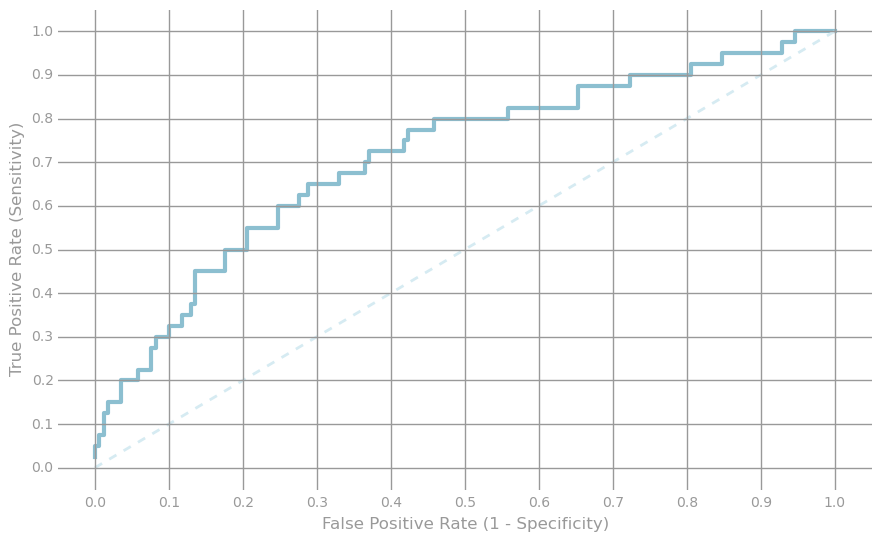

In [75]:
labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model
pass